# Static potential with fermions: 3x2 lattice m=2 and truncation l=1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit

from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm
import datetime
import scipy.sparse as sp
from time import perf_counter

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib as mpl

from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme

#local import
from Observables import *
from Fidelity_func import *

#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_74403/919128340.py:23: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [3]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import re
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "14"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

# Set the font family to a serif font available on your system (e.g., 'Times New Roman')
plt.rcParams['font.serif'] = ['Times New Roman']

# Disable TeX rendering
plt.rcParams['text.usetex'] = False

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

##### Hamiltonian

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (2, 1): 1}] {1.0, 2.23606797749979}


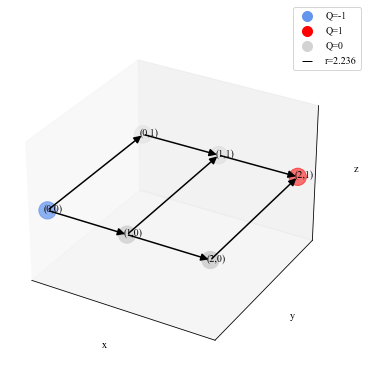

In [4]:
#class input parameters:
n_sites = [3,2]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=2
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

#static charge
latt.func_qstatic_dist()#charge=(1,0))
static_charges_values_input = latt.distances_coord
print(static_charges_values_input,set(latt.r_list))
qstat=static_charges_values_input[-1]

#qstat={(0,0):-1,(2,1):1}
#latt.func_qstatic_dist((2,1),ch_val=2)


#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st) for st in static_charges_values_input]

latt.draw_graph_func(gauss_law_fig=False,static_charges=qstat)#,savefig_dir='.')

In [5]:
from sympy import Symbol
e_op_free_input=['q_10', 'q_20', 'q_21', 'q_11', 'q_01','E_10y', 'E_20y',]#if fermions then also put charges!
e_op_free_input=[Symbol(e) for e in e_op_free_input]

# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=True)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)


ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: ['Q_00=-1', 'Q_21=1']


Eq(-E_00x - E_00y - q_00 + 1, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10x - E_10y - q_10, 0)

Eq(E_01x + E_10y - E_11x - q_11, 0)

Eq(E_10x - E_20y - q_20, 0)

Eq(E_11x + E_20y - q_21 - 1, 0)

Eq(q_00 + q_01 + q_10 + q_11 + q_20 + q_21, 0)

- E_{00x} - E_{00y} - q_{00} + 1 &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - q_{11} &= 0 \\ \nonumber
E_{10x} - E_{20y} - q_{20} &= 0 \\ \nonumber
E_{11x} + E_{20y} - q_{21} - 1 &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} + q_{20} + q_{21} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_20y**2 + (E_20y + q_20)**2 + (-E_20y + q_21 + 1)**2 + (E_10y + E_20y + q_10 + q_20)**2 + (-E_10y - E_20y + q_11 + q_21 + 1)**2 + (-E_10y - E_20y + q_01 + q_11 + q_21 + 1)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{20y}^{2} + \left(E_{20y} + q_{20}\right)^{2} + \left(- E_{20y} + q_{21} + 1\right)^{2} + \left(E_{10y} + E_{20y} + q_{10} + q_{20}\right)^{2} + \left(- E_{10y} - E_{20y} + q_{11} + q_{21} + 1\right)^{2} + \left(- E_{10y} - E_{20y} + q_{01} + q_{11} + q_{21} + 1\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_20y*Dagger(U_10y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{20y} U_{10y}^{\dagger} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(-0.5*(h.c.(y) + Dagger(Phi_1)*Phi_6 - Dagger(Phi_2)*Dagger(U_10y)*Phi_5 + Dagger(Phi_3)*Dagger(U_20y)*Phi_4) + 0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_2)*Phi_3 + Dagger(Phi_5)*Phi_4 + Dagger(Phi_6)*Phi_5)))

H_{K} = \Omega \left(- 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{6} - \Phi_{2}^{\dagger} U_{10y}^{\dagger} \Phi_{5} + \Phi_{3}^{\dagger} U_{20y}^{\dagger} \Phi_{4}\right) + 0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{2}^{\dagger} \Phi_{3} + \Phi_{5}^{\dagger} \Phi_{4} + \Phi_{6}^{\dagger} \Phi_{5}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4 + Dagger(Phi_5)*Phi_5 - Dagger(Phi_6)*Phi_6))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4} + \Phi_{5}^{\dagger} \Phi_{5} - \Phi_{6}^{\dagger} \Phi_{6}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.1551370620727539 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built


Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 5.022274017333984 seconds
>> Suppression term built.  Execution time: 0.016511917114257812 seconds


In [6]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0).simplify()
print("Partition a SparsePauliOp into sets of commuting Pauli strings:",len(Hamiltonian_Pauli_tot_vqd.group_commuting()))

Partition a SparsePauliOp into sets of commuting Pauli strings: 8


In [7]:
class_H_oprt.qop_list[::-1]+class_H_oprt.uop_list[::-1]#order of operators in tensor product and on circuit little endian ..q2q1q0

[q_01, q_11, q_21, q_20, q_10, q_00, U_20y, U_10y]

In [8]:

#print('or charges')
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.qop_list):
    print(f'qubit{i}:{k}')

qubit0:U_10y
qubit1:U_20y
qubit2:q_00
qubit3:q_10
qubit4:q_20
qubit5:q_21
qubit6:q_11
qubit7:q_01


#### Mutual info

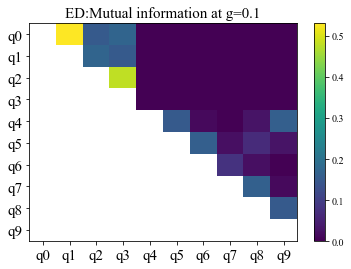

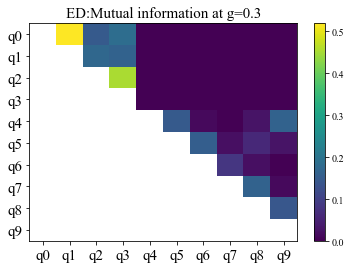

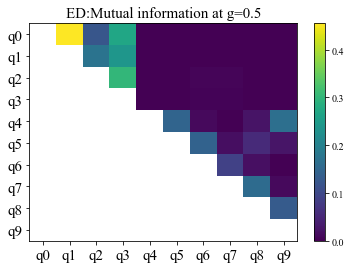

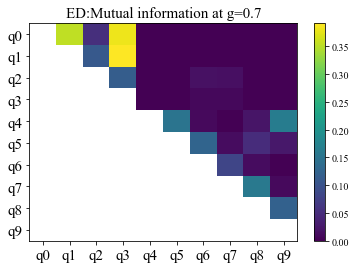

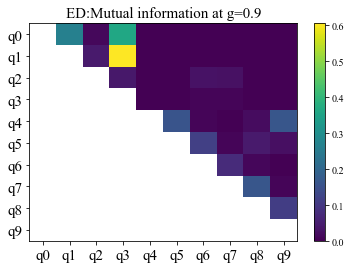

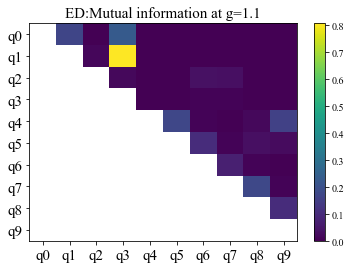

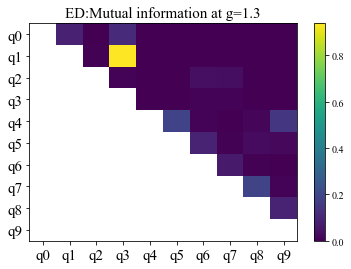

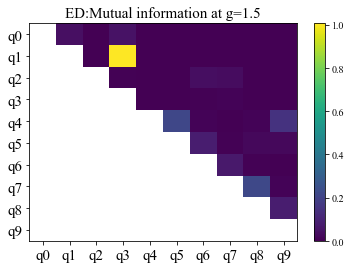

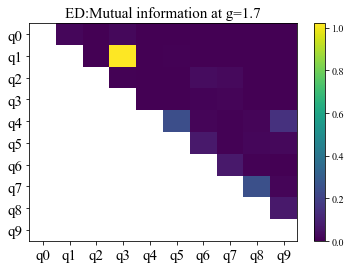

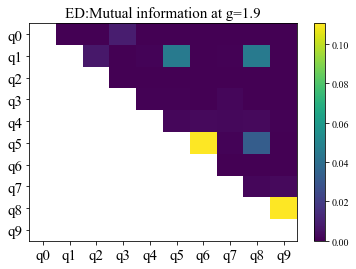

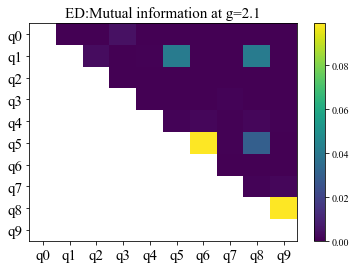

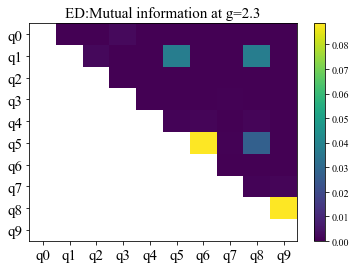

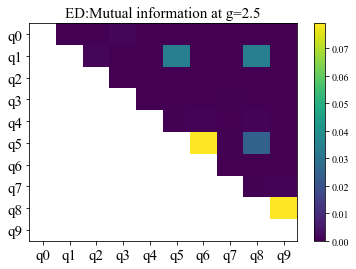

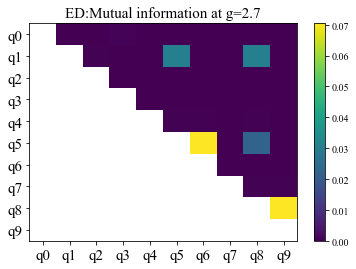

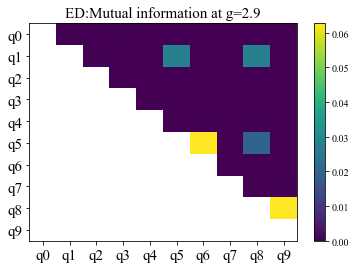

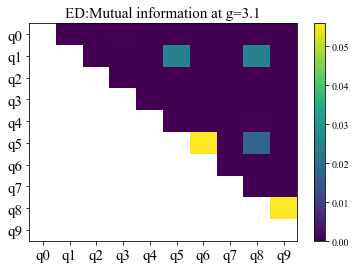

In [29]:
#MUTUAL INFO
g_list=np.arange(0.1,3.2,0.2)
for g in g_list:
    Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
    if encoding=='gray' and not sparse_pauli:
        Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
        if ngauge:
            h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
        else:
            h_b_sparse = 0
    elif encoding=='ed':
        Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
        if ngauge:
            h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
        else:
            h_b_sparse =0

    #** Exact diagonalisation
    spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
    #spectrum
    idx = spectrum.argsort()
    spectrum = spectrum[idx]
    eigenvectors_matrix = eigenvectors_matrix[:,idx]

    # thrls=2e-2
    # ed_e0_dict =dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,0][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,0][i])**2>thrls])


    # plt.figure(figsize=(16, 4))
    # plt.bar(list(ed_e0_dict.keys()), list(ed_e0_dict.values()), color='skyblue')
    # plt.xlabel('Bit Strings')
    # plt.ylabel('Probabilities')
    # plt.title(f'Dataset (>{thrls}) g={g}')#beta (1/g^2)={np.round(1/g**2,5)}')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()
    # for key,val in ed_e0_dict.items():
    #     conf = class_H_oprt.eop_config_from_string(key)
    #     print((key,val))
    #     latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,weight=conf)


    #dmatrix= np.outer(eigenvectors_matrix[:,0],eigenvectors_matrix[:,0].conj().T).reshape(2**(ngauge*n_qubits),2**(ngauge*n_qubits))#
    dmatrix=DensityMatrix(np.outer(eigenvectors_matrix[:,0],eigenvectors_matrix[:,0].conj().T))

    # list_el=[[list(range(n*n_qubits,(n+2)*n_qubits)) for n in range(0,ngauge,2)],]#XXX plaquettes
    # plot_ticksname=[['p'+str(i) for i in range(ngauge//2)],]#XXX plaquettes
    # nqbts=[ngauge//2,]

    # list_el+=[[list(range(n*n_qubits,(n+1)*n_qubits)) for n in range(ngauge)],[[i,] for i in list(range(ngauge*n_qubits))]]#gauge and single qubits
    # plot_ticksname+=[[str(i) for i in class_H_oprt.uop_list],['q'+str(i) for i in range(ngauge*n_qubits)]]
    # nqbts+=[ngauge,ngauge*n_qubits]

    list_el=[[[i,] for i in list(range(ngauge*n_qubits+n_qubits_f))]]#gauge and single qubits
    plot_ticksname=[['q'+str(i) for i in range(ngauge*n_qubits+n_qubits_f)],]
    nqbts=[ngauge*n_qubits+n_qubits_f,]

    for pairslist,tickname,nqb in zip(list_el,plot_ticksname,nqbts):
        part_trace={}
        for i_idx,i in enumerate(pairslist):
            for j_idx,j in enumerate(pairslist):
                if i_idx<j_idx:
                    # print(i,[k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in i])
                    # print(j,[k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in j])
                    # print(i+j,[k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in i+j])
                    part_trace['g'+str(i_idx+1)]=qinf.partial_trace(dmatrix, [k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in i]) #System A
                    part_trace['g'+str(j_idx+1)]=qinf.partial_trace(dmatrix, [k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in j]) #System B
                    part_trace['g'+str(i_idx+1)+'g'+str(j_idx+1)]=qinf.partial_trace(dmatrix, [k for k in list(range(ngauge*n_qubits+n_qubits_f)) if k not in i+j]) #System A+B

        entropy_dict=np.zeros((nqb,nqb))
        for i_idx,i in enumerate(pairslist):
            for j_idx,j in enumerate(pairslist):
                if i_idx<j_idx:#entropy S(A)+S(B)-S(A+B)
                    ent_i=entropy(part_trace['g'+str(i_idx+1)])
                    ent_j=entropy(part_trace['g'+str(j_idx+1)])
                    entij=entropy(part_trace['g'+str(i_idx+1)+'g'+str(j_idx+1)])
                    entropy_dict[i_idx,j_idx]=ent_i+ent_j-entij

                else:
                    entropy_dict[i_idx,j_idx]=np.nan
        vmax = np.nanmax(entropy_dict)
        #print(f'Entropy at g{g}:\n',entropy_dict)
        plt.imshow(entropy_dict,aspect='auto',origin='upper',interpolation='None',cmap='viridis',vmin=0,vmax=vmax)
        #range of the colorbar
        plt.colorbar()
        plt.yticks(range(nqb),tickname,fontsize=15)
        plt.xticks(range(nqb),tickname,fontsize=15)
        plt.xticks(fontsize=15)
        plt.title('ED:Mutual information at g='+str(np.round(g,3)),fontsize=15)
        plt.show()

##### Quantum circuit: with fermions

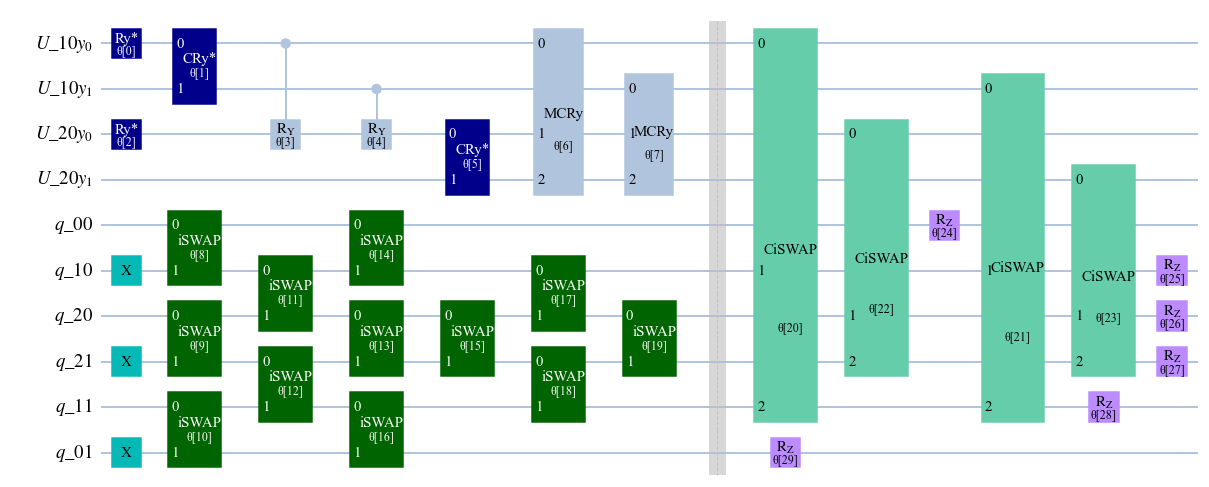

In [13]:
nlayers= 1
entanglement='full'#triangular,linear,full
rzlayer=False
ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f,gauge_list= class_H_oprt.uop_list,ferm_list=class_H_oprt.qop_list)
params = lambda i: Parameter(f"θ[{i}]")

qc_gauge,first_layer_par,th_gauge= ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)

qreg_g=[]
qreg_f=[]
if ansatz_class.gauge_list:
    for i in [str(k) for k in ansatz_class.gauge_list]:
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits,name=i))
else:
    for i in range(ansatz_class.ngauge):
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits,name=f'g{i}'))
if ansatz_class.ferm_list:
    for f in [str(i) for i in ansatz_class.ferm_list]:
        qreg_f.append(QuantumRegister(1,name=f))
else:
    for i in range(ansatz_class.nfermions):
        qreg_f.append(QuantumRegister(1,name=f'f{i}'))

qc_tot2 = QuantumCircuit(*qreg_g,*qreg_f)

#gauge part
qc_tot2.compose(qc_gauge,range(ansatz_class.ngauge*ansatz_class.n_qubits),inplace=True)

#fermionic part
qc_ferm,th = ansatz_class.fermionic_circuit(th_ferm=th_gauge,nlayers=2)
qc_tot2.compose(qc_ferm,range(ansatz_class.ngauge*ansatz_class.n_qubits,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions),inplace=True)

qc_tot2.barrier()

for pair in [[0,5,8],[1,5,8],[2,6,7],[3,6,7]]:
    qc_tot2.append(Ansatz.CiSwap2(params(th)),pair)
    th+=1

#rz layer for fermions
for i in range(ansatz_class.ngauge*ansatz_class.n_qubits,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions):
    qc_tot2.rz(params(th),i)
    th+=1


qc_tot2.draw('mpl',fold=50,
             style=ansatz_class.style)

In [14]:
print("Total numer of gates",qc_tot2.decompose(reps=6).count_ops())

Total numer of gates OrderedDict([('u', 247), ('cx', 152), ('barrier', 1)])


#### Read datafile

Files considered are:
1. run with final string break configuration as initial point,
2. run with 4 configurations vacuum for sites and all cases for gauge fields.

Data saved: coupling "g", exat ground state "ed0", exact ground state eigenstate probabilities (ed_dict={bin str: probability}), 
VQE results, ground state with NFT optimizer and 10^4 shots "vqe0", standard deviation "std_dev", ground state eigenstate probabilities (vqe_dict={bin str: probability}, fidelity, optimal_point to be used with the circuit and Hamiltonian above.

Data computed with electric basis and truncation l=1

In [15]:
nshots=10000 #shots used

In [16]:
#read data from file
def read_datafile_glist(filetxt,nshots=None):
    """Read data from files with VQE and exact diagonalisation results.
    Function specific for that type of files."""
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_g=r'g=(-?\d+\.\d+)'
    pattern_ed = r'ed0=(-?\d+\.\d+)'
    pattern_ed_dict=r'ed_dict=\{([\s\S]+?)\}'

    pattern_vqd = r'vqe0=(-?\d+\.\d+)'
    pattern_vqd_dict =r'vqe_dict=\{([\s\S]+?)\}'
    if nshots:
        pattern_std_dev = r'std_dev=(-?\d+\.\d+)'
    pattern_fidelity = r'fidelity=(\d+\.\d+)'
    pattern_parameters = r'optimal_point=\[([\s\d\.\-\+eE]+)\]'

    g_values=[]
    ed_values = []
    dict_ed=[]
    vqe_values = []
    dict_vqe=[]
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, 'r') as file:
        data = file.read()

        g_values = np.array(list(map(float, re.findall(pattern_g, data))))
        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqe_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        for k,g in enumerate(g_values):
            # Extract dict_ed string
            list_ed_tmp=[el for el in re.findall(pattern_ed_dict, data)[k].split()]
            #dict index even keys , index odd values
            dict_ed_tmp = {eval(list_ed_tmp[i][:-1]):eval(list_ed_tmp[i+1]) for i in range(0,len(list_ed_tmp),2)}
            dict_ed_tmp = {key: float(v[0]) if isinstance(v, tuple) else float(v) for key, v in dict_ed_tmp.items()}


            dict_ed.append(dict_ed_tmp)

            # Extract dict_vqe string
            list_vqd_tmp=[el for el in re.findall(pattern_vqd_dict, data)[k].split()]
            #dict index even keys , index odd values
            dict_vqe_tmp = {eval(list_vqd_tmp[i][:-1]):eval(list_vqd_tmp[i+1]) for i in range(0,len(list_vqd_tmp),2)}
            dict_vqe_tmp = {key: float(v[0]) if isinstance(v, tuple) else float(v) for key, v in dict_vqe_tmp.items()}

            dict_vqe.append(dict_vqe_tmp)

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        #print(parameters_matches)

        parameters_list = [np.array(list(map(float, match.group(1).split()))) for match in parameters_matches]
        #print(parameters_list)
    return g_values,ed_values,dict_ed, vqe_values, std_dev_values,dict_vqe, fidelity_values, parameters_list

Data plotted in the following are from g=0.3 (better visualisation of the string breaking)

Higher fidelity 1st case: 0.9627 0.954
Higher fidelity 2nd case: 0.9703 0.9706
Higher fidelity 2nd case: 0.9717 0.9733
Higher fidelity 1st case: 0.973 0.9728
Higher fidelity 2nd case: 0.9688 0.969
Higher fidelity 1st case: 0.9646 0.9635
Higher fidelity 2nd case: 0.9512 0.9554
Higher fidelity 2nd case: 0.9246 0.9477
Higher fidelity 2nd case: 0.9008 0.9482
Higher fidelity 1st case: 0.9983 0.0002
Higher fidelity 1st case: 0.9989 0.0001
Higher fidelity 1st case: 0.9993 0.0001
Higher fidelity 1st case: 0.9996 0.0002
Higher fidelity 1st case: 0.9996 0.0006
Higher fidelity 1st case: 0.9997 0.0015
Higher fidelity 1st case: 0.9998 0.0023


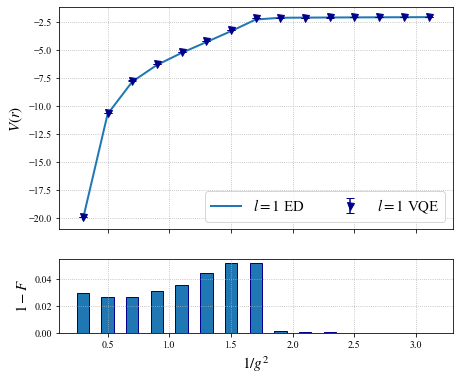

In [18]:
#Read data file
g_values_file,ed_values_file,dict_ed_file, vqe_values_file, std_dev_values_file,dict_vqe_file, fidelity_values_file, parameters_list_file=read_datafile_glist('static_potential_3x2_m2_omega1_l1_mutualinfoansatz.txt',nshots=nshots)
g_values_file_v2,ed_values_file_v2,dict_ed_file_v2, vqe_values_file_v2, std_dev_values_file_v2,dict_vqe_file_v2, fidelity_values_file_v2, parameters_list_file_v2=read_datafile_glist('static_potential_3x2_m2_omega1_l1_mutualinfoansatz_v2.txt',nshots=nshots)

width=510
#select in the two files which one has hogher fidelity in the results. The difference is related to the choice of the initial point.
for fid,fid_2,i in zip(fidelity_values_file,fidelity_values_file_v2,range(len(g_values_file))):
    if fid>=fid_2:#first run with final string break configuration as initial point
        print('Higher fidelity 1st case:',np.round(fid,4),np.round(fid_2,4))
    else:#second run with 4 configurations vacuum for sites and all cases for gauge fields
        print('Higher fidelity 2nd case:',np.round(fid,4),np.round(fid_2,4))
        g_values_file[i]=g_values_file_v2[i]
        ed_values_file[i]=ed_values_file_v2[i]
        dict_ed_file[i]=dict_ed_file_v2[i]
        vqe_values_file[i]=vqe_values_file_v2[i]
        dict_vqe_file[i]=dict_vqe_file_v2[i]
        std_dev_values_file[i]=std_dev_values_file_v2[i]
        fidelity_values_file[i]=fidelity_values_file_v2[i]
        parameters_list_file[i]=parameters_list_file_v2[i]


fig,ax =plt.subplots(2,figsize=(set_size(width)[0],6),sharex=True,gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(g_values_file[1:],ed_values_file[1:],markersize=6,markeredgewidth=2,label=f'$l=1$ ED',linewidth=2)
ax[0].errorbar(g_values_file[1:],vqe_values_file[1:],yerr=std_dev_values_file[1:],marker='v',markersize=7,color='darkblue',label='$l=1$ VQE',linestyle='',capsize=4)
ax[0].set_ylabel(r'$V(r)$',fontsize=15)
ax[0].legend(fontsize=15,ncols=3,loc='lower right')

#ax[1].bar(g_list,np.abs(np.array(vqe_results)-np.array(ed_results)/np.array(ed_results)), edgecolor='black',width=0.1)
ax[1].bar(g_values_file[1:],1-fidelity_values_file[1:], edgecolor='darkblue',width=0.1)

ax[1].set_ylabel(r'$1-F$',fontsize=15)
ax[1].set_xlabel(r'$1/g^2$',fontsize=15)


for i in [0,1]:
    ax[i].grid(True,which='both',linestyle='dotted')


##### Coulomb configuration

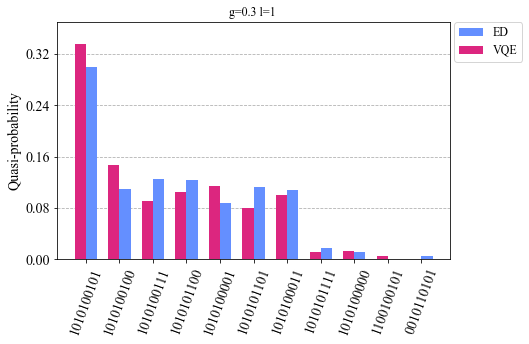

In [19]:
from qiskit.visualization import plot_distribution
width=510
fig_hist=plot_distribution([dict_ed_file[1] ,dict_vqe_file[1] ], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={np.round(g_values_file[1],2)} l=1 ')
fig_hist

('1010100001', 0.10820938594207294)


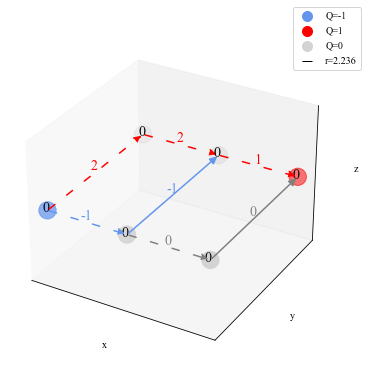

('1010100100', 0.13878587319450578)


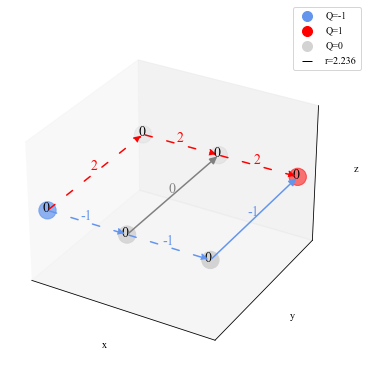

('1010100101', 0.31746061001524395)


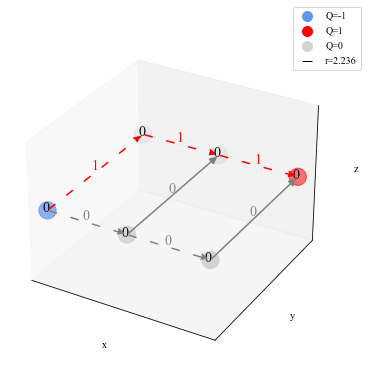

In [20]:
for key,val in {key:val for key,val in dict_vqe_file[1].items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')

##### Linear configurations (strings between static charges)

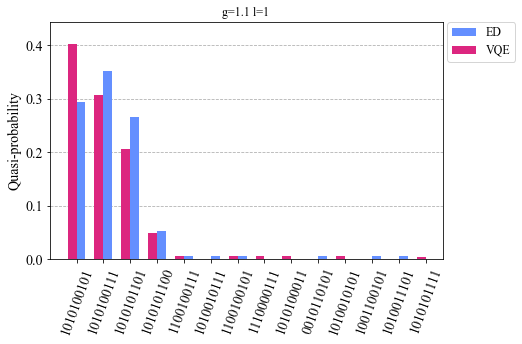

In [21]:
from qiskit.visualization import plot_distribution
width=510
fig_hist=plot_distribution([dict_ed_file[5] ,dict_vqe_file[5] ], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={np.round(g_values_file[5],2)} l=1 ')
fig_hist

('1010100101', 0.3887858350797497)


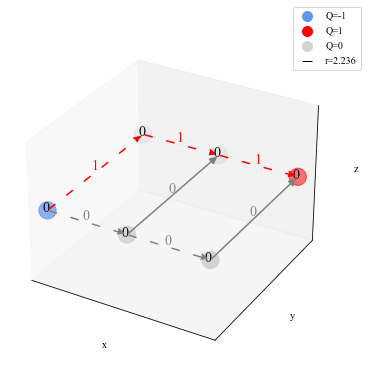

('1010100111', 0.29710863868075604)


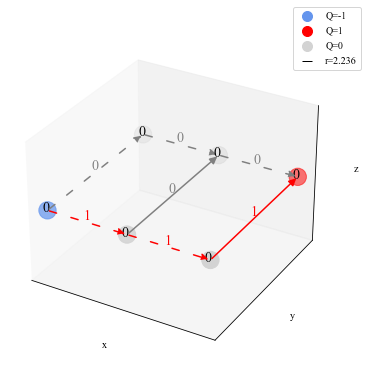

('1010101101', 0.19920312021713782)


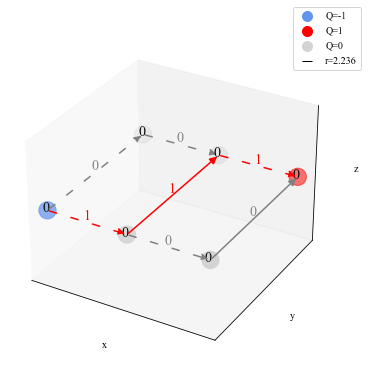

In [22]:
for key,val in {key:val for key,val in dict_vqe_file[5].items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')

##### String breaking (a single configuration without electric fluxes)

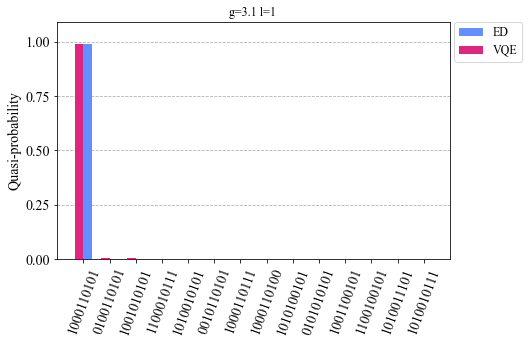

In [23]:
from qiskit.visualization import plot_distribution
width=510
fig_hist=plot_distribution([dict_ed_file[-1] ,dict_vqe_file[-1] ], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={np.round(g_values_file[-1],2)} l=1 ')
fig_hist

('1000110101', 0.9899240582790358)


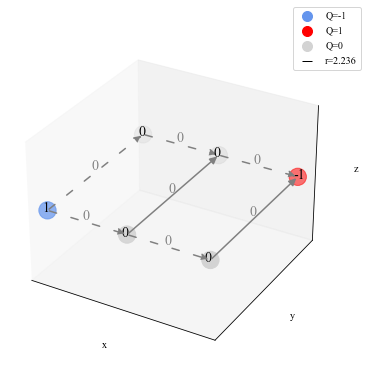

In [24]:
for key,val in {key:val for key,val in dict_vqe_file[-1].items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')